In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Infer Markov Chain transition matrix from political regime time-series data

In [2]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')

In [3]:
nCountries = len(timeSeries['country'].unique()) # numer of countries

In [18]:
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity', 'polity2'])

In [25]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist',score='polity2'):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')[score].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

def computeSteadyStateBruteForce(transitionMatrix,nSteps,initialCondition=0):
    # computes it the brutal way with iterating the transition
    
    n=transitionMatrix.shape[0] # number of Markov states
    
    if initialCondition==0:
        # if it is zero use a random vector
        x = np.random.rand(n)
        x = x / np.sum(x)
    else:
        # set it to the intial condition that we provided
        x= initialCondition
    # fo over each step
    for i in np.arange(nSteps):
        #x= P_allCountries.dot(x)
        x= x.dot(transitionMatrix)
    
    return(x)

def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


def simulateMarkovChain(transitionMatrix,initialCondition,nSteps=100):
    
    n=transitionMatrix.shape[0] # number of states
    
    stateVector=[initialCondition]
    for i in np.arange(nSteps):
        newstate = np.random.choice(np.arange(n), p=transitionMatrix[stateVector[i],:])
        stateVector.append(newstate)
    return(stateVector)
    

def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  


def createSimpleMarkovChain():
    
    P=np.zeros((2,2)) # empty transition matrix
    
    P[0,0] = 0.9
    P[0,1] = 0.1
    P[1,0] = 0.5
    P[1,1] = 0.5
    
    return(P)

# Analyse the actual data

In [26]:
P_allCountries_Bayes = estimateTransitionMatrix(timeSeries,approach='bayesian',score="polity")


Text(0.5, 1.0, 'estimated transition probabilities, $p_{ij}$ [$\\%$]')

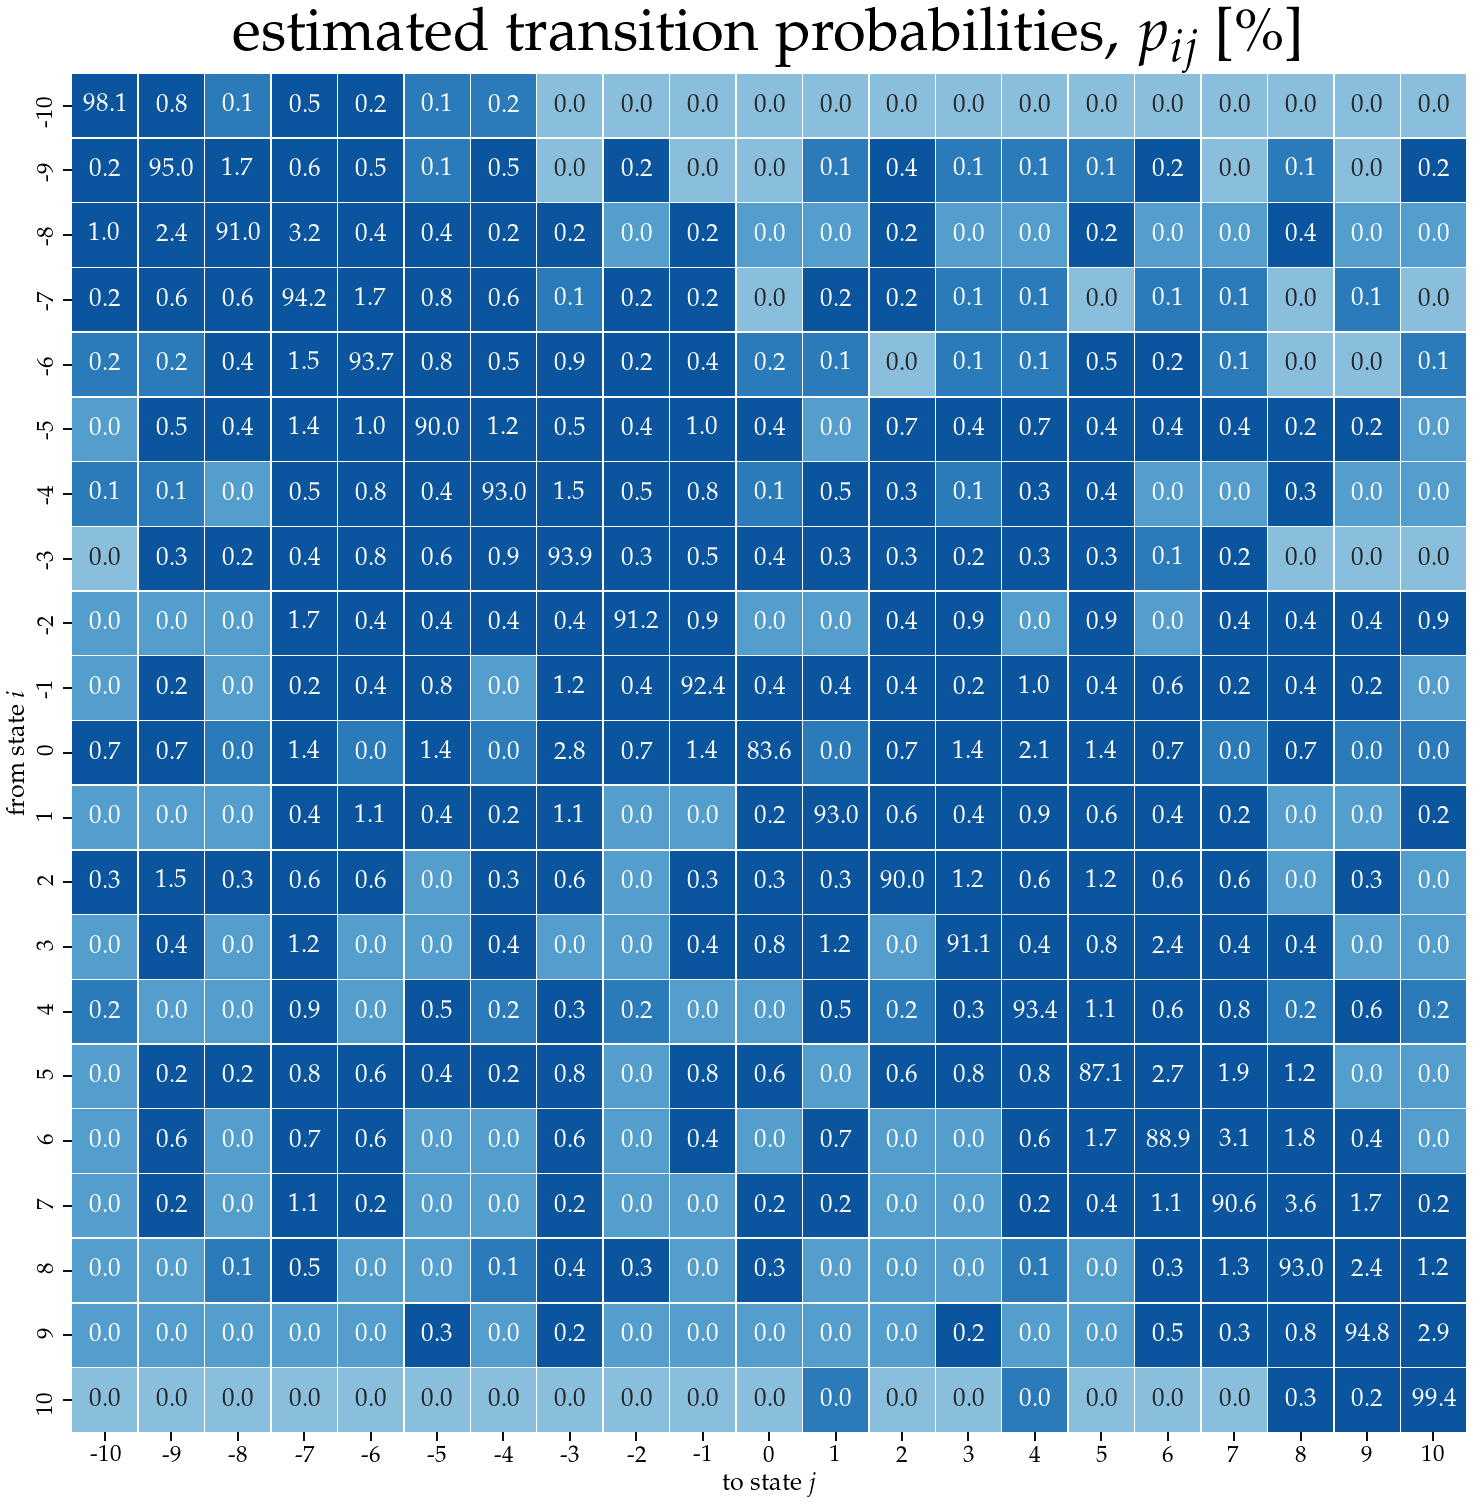

In [27]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Bayes*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Bayes.min(), vmax=P_allCountries_Bayes.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$]',size=60)
#plt.savefig('./../results/figures/Fig2-estimatedTransitionProbabilities.pdf',bbox_inches='tight')

### Steady State

In [28]:
def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


In [29]:
# compute steady state
steadyStateEV = computeSteadyStateEV(P_allCountries_Bayes)

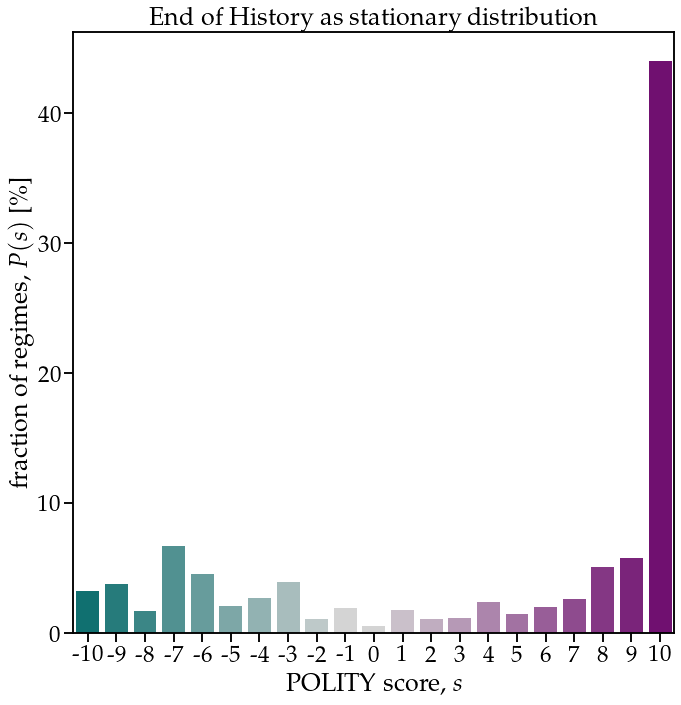

In [38]:
# plot the steady state
plt.figure(figsize=(10,10))
steadyState=pd.DataFrame()
steadyState['fraction'] = 100*steadyStateEV
steadyState['regime'] = np.arange(-10,11,1)

teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()


g=sns.barplot(x="regime", y="fraction", data=steadyState,palette=clrsL)


# sns.scatterplot(x=np.arange(0,21),y=100*hist1800/np.sum(hist1800),marker='d',color=sns.xkcd_rgb['light blue'], s=100,zorder=10,label=r'1800')
# sns.scatterplot(x=np.arange(0,21),y=100*hist2018/np.sum(hist2018),marker='o',color=sns.xkcd_rgb['orange'], s=100, zorder=11,label=r'2018')
#plt.legend(loc=0)
plt.tight_layout()
plt.title('End of History as stationary distribution')
plt.xlabel(r'POLITY score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')

plt.savefig('./fig/FigSI-EoH_Polity.pdf',bbox_inches='tight')

#plt.savefig('./figures/distributionAndSteadyStateBarplot.pdf')
#plt.savefig('./../results/figures/Fig4-distributionAndSteadyStateBarplot.pdf',bbox_inches='tight')




## For POLITY2 score

In [31]:
P_allCountries_Bayes_polity2 = estimateTransitionMatrix(timeSeries,approach='bayesian',score="polity2")

steadyStateEV_polity2 = computeSteadyStateEV(P_allCountries_Bayes_polity2)

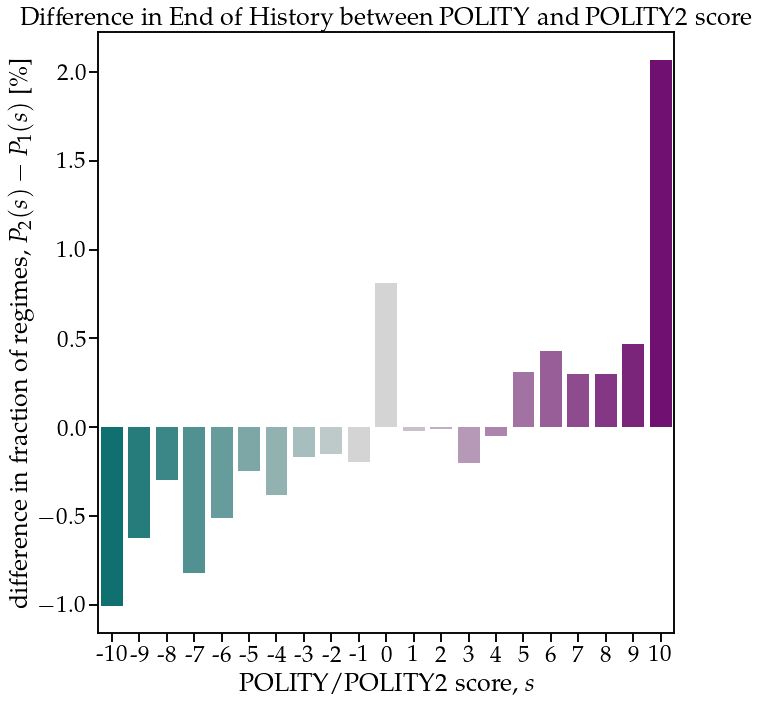

In [37]:
# plot the steady state
plt.figure(figsize=(10,10))
steadyState=pd.DataFrame()
steadyState['fraction'] = 100*(steadyStateEV_polity2-steadyStateEV)
steadyState['regime'] = np.arange(-10,11,1)

teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()


g=sns.barplot(x="regime", y="fraction", data=steadyState,palette=clrsL)


# sns.scatterplot(x=np.arange(0,21),y=100*hist1800/np.sum(hist1800),marker='d',color=sns.xkcd_rgb['light blue'], s=100,zorder=10,label=r'1800')
# sns.scatterplot(x=np.arange(0,21),y=100*hist2018/np.sum(hist2018),marker='o',color=sns.xkcd_rgb['orange'], s=100, zorder=11,label=r'2018')
#plt.legend(loc=0)
plt.tight_layout()
plt.title('Difference in End of History between POLITY and POLITY2 score')
plt.xlabel(r'POLITY/POLITY2 score, $s$')
plt.ylabel(r'difference in fraction of regimes, $P_2(s)-P_1(s)$ [$\%$]')

plt.savefig('./fig/FigSI-EoH_Polity_difference.pdf',bbox_inches='tight')


#plt.savefig('./figures/distributionAndSteadyStateBarplot.pdf')
#plt.savefig('./../results/figures/Fig4-distributionAndSteadyStateBarplot.pdf',bbox_inches='tight')


